In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

#Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import imutils
import glob
import cv2
import shutil
from tqdm import tqdm_notebook,tqdm
from fastai.vision import *
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [0]:
# install pnslib
!pip install git+git://github.com/PnS2019/pnslib.git
from pnslib import utils

  Cloning git://github.com/PnS2019/pnslib.git to /tmp/pip-req-build-duac9tyz
  Running command git clone -q git://github.com/PnS2019/pnslib.git /tmp/pip-req-build-duac9tyz
  Created wheel for pnslib: filename=pnslib-0.1.0a1-cp36-none-any.whl size=1489619 sha256=af7d6857e774ed4ee803d337f1dd6ba674fe731809f26cd0d45ca91d88a0b728
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_1l606m/wheels/a2/8e/a9/c62e72840009deaa723b3a113d5c3b90acac77098d16e90eca
Successfully built pnslib


#Downloading data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mantispraying","key":"2d6deddec71f566064539bce80a435b5"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:14<00:00, 112MB/s] 
100% 1.33G/1.33G [00:14<00:00, 101MB/s]


#Data Preprocessing

In [0]:
!unzip '/content/celeba-dataset.zip' -d '/content/celeba-dataset/'

In [0]:
## Loading Haar Cascade
## Taken from https://github.com/opencv/opencv/tree/master/data/haarcascades
face_cascade = cv2.CascadeClassifier(utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))

In [0]:
def face_extractor(origin, destination, fc):
    ## Importing image using open cv
    img = cv2.imread(origin,1)

    ## Resizing to constant width
    img = imutils.resize(img, width=200)
    
    ## Finding actual size of image
    H,W,_ = img.shape
    
    ## Converting BGR to RGB
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ## Detecting faces on the image
    face_coord = fc.detectMultiScale(gray,1.2,10,minSize=(50,50))
    
    ## If only one face is found
    if len(face_coord) == 1:
        X, Y, w, h = face_coord[0]
    
    ## If no face found --> SKIP
    elif len(face_coord)==0:
        return None
    
    ## If multiple faces are found take the one with largest area
    else:
        max_val = 0
        max_idx = 0
        for idx in range(len(face_coord)):
            _, _, w_i, h_i = face_coord[idx]
            if w_i*h_i > max_val:
                max_idx = idx
                max_val = w_i*h_i
            else:
                pass
            
            X, Y, w, h = face_coord[max_idx]
    
    ## Crop and export the image
    img_cp = img[
            max(0,Y - int(0.35*h)): min(Y + int(1.35*h), H),
            max(0,X - int(w*0.35)): min(X + int(1.35*w), W)
        ].copy()
    
    cv2.imwrite(destination, img_cp)

In [0]:
## Defining destination path
path = '/content/celeba-dataset/faces/'
## Finding all the images in the folder
item_list = glob.glob('/content/celeba-dataset/img_align_celeba/img_align_celeba/*.jpg')
print(len(item_list))

202599


In [0]:
pathq = Path(path)
pathq.mkdir(parents=True, exist_ok=True)

In [0]:
## Will run for about an hour and a half 
for org in tqdm_notebook(item_list):
  face_extractor(origin = org, destination = path+org.split('/')[-1], fc=face_cascade)

In [0]:
item_list = glob.glob(path+'*.jpg')
print(len(item_list))

In [0]:
## Findign all the images and separating in training and validation
item_list = glob.glob(path+'*.jpg')
Path(path+'training/').mkdir(parents=True, exist_ok=True)
Path(path+'validation/').mkdir(parents=True, exist_ok=True)
for idx in tqdm_notebook(range(1,202600)):
    if idx <= 182637:
        destination = path+'training/'
    else:
        destination = path+'validation/'
    try:
        shutil.move(
            path+str(idx).zfill(6)+'.jpg', 
            destination+str(idx).zfill(6)+'.jpg'
        )
    except:
        pass

In [0]:
item_list1 = glob.glob(path+'training/*.jpg')
print(len(item_list1))
item_list2 = glob.glob(path+'validation/*.jpg')
print(len(item_list2))

0
0


In [0]:
## Combining all label attributes
label_df = pd.read_csv('/content/celeba-dataset/list_attr_celeba.csv')
column_list = pd.Series(list(label_df.columns)[1:])

def label_generator(row):
    return(' '.join(column_list[[True if i==1 else False for i in row[column_list]]]))

label_df['label'] = label_df.apply(lambda x: label_generator(x), axis=1)
label_df = label_df.loc[:,['image_id','label']]
label_df.to_csv('/content/celeba-dataset/labels.csv')
print(label_df)

          image_id                                              label
0       000001.jpg  Arched_Eyebrows Attractive Brown_Hair Heavy_Ma...
1       000002.jpg  Bags_Under_Eyes Big_Nose Brown_Hair High_Cheek...
2       000003.jpg  Big_Lips Blurry Male Narrow_Eyes No_Beard Poin...
3       000004.jpg  Attractive No_Beard Pointy_Nose Straight_Hair ...
4       000005.jpg  Arched_Eyebrows Attractive Big_Lips Heavy_Make...
...            ...                                                ...
202594  202595.jpg  Attractive Big_Lips Blond_Hair No_Beard Wearin...
202595  202596.jpg  Bangs Big_Lips Blond_Hair High_Cheekbones Male...
202596  202597.jpg  Black_Hair Eyeglasses High_Cheekbones Male Mou...
202597  202598.jpg  Arched_Eyebrows Attractive Big_Lips Black_Hair...
202598  202599.jpg  Arched_Eyebrows Attractive Blond_Hair Heavy_Ma...

[202599 rows x 2 columns]


In [0]:
## Attachhing label to correct file names
item_list = glob.glob('/content/celeba-dataset/faces/*/*.jpg')
print(len(item_list))
item_df = pd.DataFrame({'image_name':pd.Series(item_list).apply(lambda x: x.split('/')[-2]+'/'+x.split('/')[-1])})
print(item_df)
item_df['image_id'] = item_df.image_name.apply(lambda x: x.split('/')[1])
print(item_df)

175620
                   image_name
0       validation/185761.jpg
1       validation/194361.jpg
2       validation/193420.jpg
3       validation/189369.jpg
4       validation/193574.jpg
...                       ...
175615    training/115960.jpg
175616    training/159529.jpg
175617    training/150957.jpg
175618    training/066993.jpg
175619    training/056530.jpg

[175620 rows x 1 columns]
                   image_name    image_id
0       validation/185761.jpg  185761.jpg
1       validation/194361.jpg  194361.jpg
2       validation/193420.jpg  193420.jpg
3       validation/189369.jpg  189369.jpg
4       validation/193574.jpg  193574.jpg
...                       ...         ...
175615    training/115960.jpg  115960.jpg
175616    training/159529.jpg  159529.jpg
175617    training/150957.jpg  150957.jpg
175618    training/066993.jpg  066993.jpg
175619    training/056530.jpg  056530.jpg

[175620 rows x 2 columns]


In [0]:
## Creating final label set
label_df = pd.read_csv('/content/celeba-dataset/labels.csv')
label_df = label_df.merge(item_df, on='image_id', how='inner')
print(label_df)
label_df.rename(columns={'label':'tags'}, inplace=True)
label_df.loc[:,['image_name','tags']].to_csv('/content/celeba-dataset/faces/labels.csv', index=False)

        Unnamed: 0    image_id  \
0                0  000001.jpg   
1                1  000002.jpg   
2                4  000005.jpg   
3                5  000006.jpg   
4                6  000007.jpg   
...            ...         ...   
175615      202594  202595.jpg   
175616      202595  202596.jpg   
175617      202596  202597.jpg   
175618      202597  202598.jpg   
175619      202598  202599.jpg   

                                                    label  \
0       Arched_Eyebrows Attractive Brown_Hair Heavy_Ma...   
1       Bags_Under_Eyes Big_Nose Brown_Hair High_Cheek...   
2       Arched_Eyebrows Attractive Big_Lips Heavy_Make...   
3       Arched_Eyebrows Attractive Big_Lips Brown_Hair...   
4       5_o_Clock_Shadow Attractive Bags_Under_Eyes Bi...   
...                                                   ...   
175615  Attractive Big_Lips Blond_Hair No_Beard Wearin...   
175616  Bangs Big_Lips Blond_Hair High_Cheekbones Male...   
175617  Black_Hair Eyeglasses High_Cheekbo

#Creating Model

## Creating a databunch

In [0]:
path = Path('/content/celeba-dataset/faces/')

In [0]:
## Function to filter validation samples
def validation_func(x):
    return 'validation' in x

In [0]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=30, max_lighting=0.3)

In [0]:
# shutil.copy2('/content/celeba-dataset/'+'labels.csv','/content/gdrive/My Drive/Colab Notebooks')

In [0]:
# import os
# import shutil

# def recursive_copy(src, dest):
#     """
#     Copy each file from src dir to dest dir, including sub-directories.
#     """
#     for item in tqdm_notebook(os.listdir(src)):
#         file_path = os.path.join(src, item)

#         # if item is a file, copy it
#         if os.path.isfile(file_path):
#             shutil.move(file_path, dest)

#         # # else if item is a folder, recurse 
#         # elif os.path.isdir(file_path):
#         #     new_dest = os.path.join(dest, item)
#         #     os.mkdir(new_dest)
#         #     recursive_copy(file_path, new_dest)
# recursive_copy(root_dir,base_dir+'del')

In [0]:
src = (ImageList.from_csv(path, csv_name='labels.csv')
       .split_by_valid_func(validation_func)
       .label_from_df(cols='tags',label_delim=' '))
print(src)
data = (src.transform(tfms, size=128)
       .databunch(bs=256).normalize(imagenet_stats))

LabelLists;

Train: LabelList (158144 items)
x: ImageList
Image (3, 186, 186),Image (3, 209, 200),Image (3, 218, 200),Image (3, 177, 177),Image (3, 196, 196)
y: MultiCategoryList
Arched_Eyebrows;Attractive;Brown_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Pointy_Nose;Smiling;Straight_Hair;Wearing_Earrings;Wearing_Lipstick;Young,Bags_Under_Eyes;Big_Nose;Brown_Hair;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Smiling;Young,Arched_Eyebrows;Attractive;Big_Lips;Heavy_Makeup;Narrow_Eyes;No_Beard;Pointy_Nose;Wearing_Lipstick;Young,Arched_Eyebrows;Attractive;Big_Lips;Brown_Hair;Heavy_Makeup;Mouth_Slightly_Open;No_Beard;Wavy_Hair;Wearing_Earrings;Wearing_Lipstick;Young,5_o_Clock_Shadow;Attractive;Bags_Under_Eyes;Big_Lips;Big_Nose;Black_Hair;Bushy_Eyebrows;Male;No_Beard;Pointy_Nose;Straight_Hair;Young
Path: /content/celeba-dataset/faces;

Valid: LabelList (17476 items)
x: ImageList
Image (3, 200, 199),Image (3, 231, 200),Image (3, 207, 200),Image (3, 212, 200),Image (3, 216, 2

In [0]:
print(data.c,'\n',data.classes)

40 
 ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


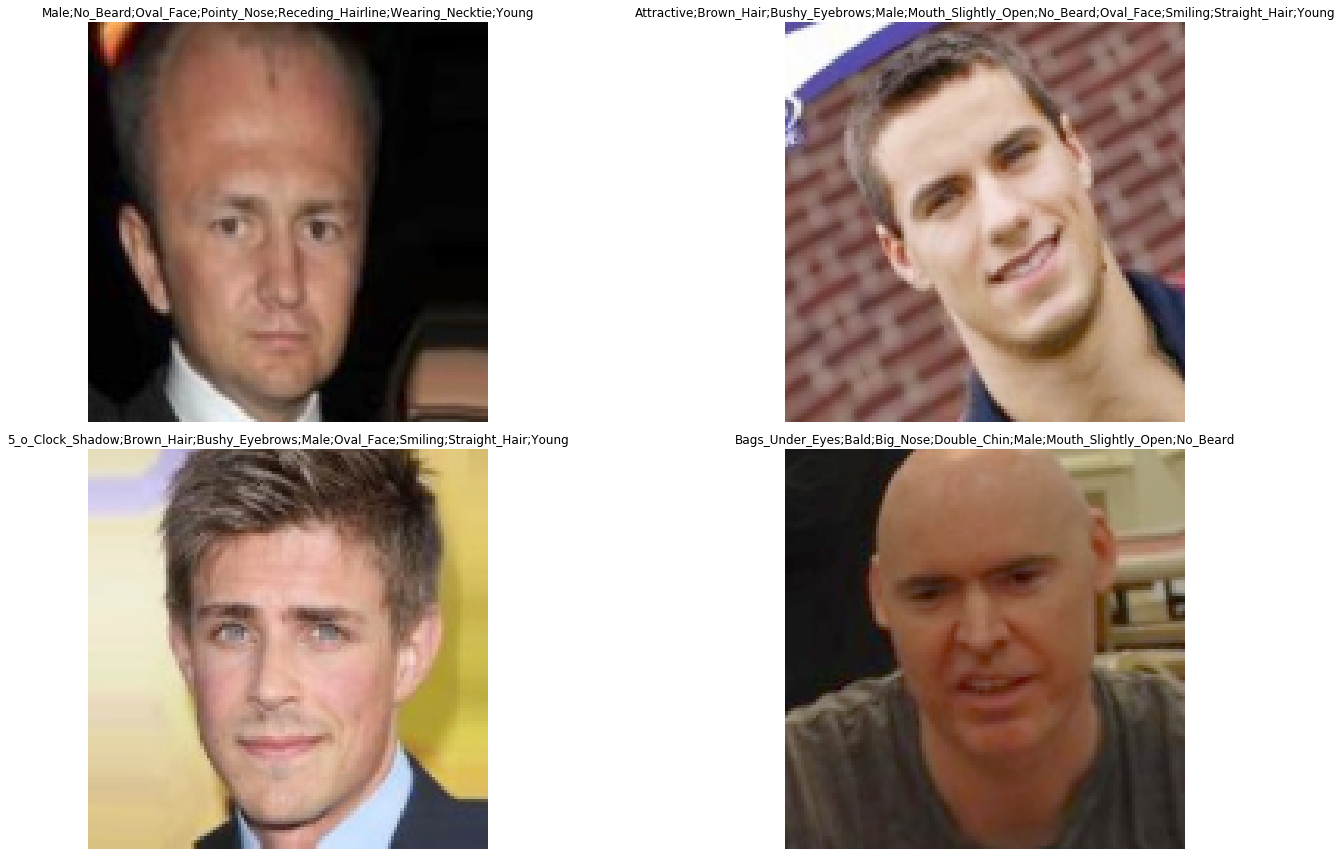

In [0]:
data.show_batch(rows=2, figsize=(20,12))

## Model

We are going to use a resnet50 pretrained model and do transfer learning on CelebA dataset.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
acc_03 = partial(accuracy_thresh, thresh=0.3)
acc_04 = partial(accuracy_thresh, thresh=0.4)
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, acc_03, acc_04, acc_05, f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


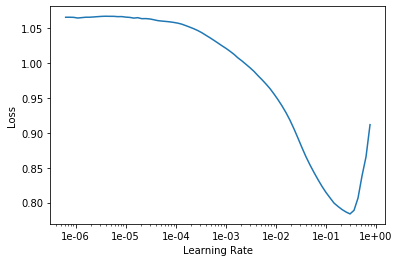

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.241422,0.231053,0.854257,0.882512,0.893819,0.896016,0.813257,10:42


In [0]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.236025,0.226840,0.856620,0.881804,0.894102,0.897854,0.816025,09:45
1,0.223704,0.214570,0.868203,0.891491,0.901047,0.903172,0.826532,09:28
2,0.214489,0.206945,0.867814,0.892969,0.903845,0.906847,0.835240,09:30
3,0.211388,0.205007,0.871355,0.895329,0.905395,0.907713,0.836217,09:46


In [0]:
learn.save('ff_stage-1-rn50')

Tuning the whole model

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


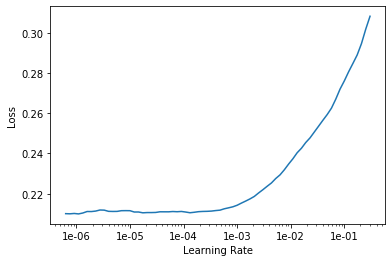

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.209195,0.202506,0.871641,0.895488,0.905704,0.908814,0.838421,09:13
1,0.204357,0.199600,0.873343,0.897067,0.907188,0.909936,0.842092,09:08
2,0.196408,0.195228,0.880824,0.900993,0.909839,0.912062,0.844887,09:08
3,0.191250,0.190498,0.884675,0.904088,0.912025,0.914350,0.848376,09:06
4,0.188224,0.189189,0.885489,0.904621,0.912536,0.914946,0.849588,09:14


In [0]:
learn.save('ff_stage-2-rn50')

## Further Training

In [0]:
data = (src.transform(tfms, size=256)
       .databunch(bs=64).normalize(imagenet_stats))

In [0]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.5)
learn = cnn_learner(data, models.resnet50, pretrained=False,metrics=[acc_05, f_score])
learn.load("ff_stage-2-rn50")

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


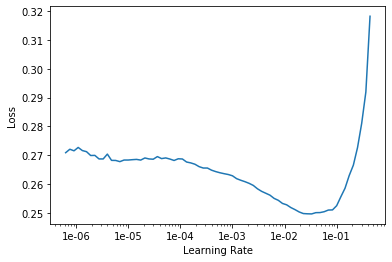

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.199127,0.191591,0.913765,0.762412,22:25


In [0]:
learn.save('ff_stage-1-256-rn50')

In [0]:
learn.export()

In [0]:
shutil.copy2('/content/celeba-dataset/'+'faces/export.pkl','/content/gdrive/My Drive/Colab Notebooks')

'/content/gdrive/My Drive/Colab Notebooks/export.pkl'

## Visualize

In [0]:
learn = cnn_learner(data, models.resnet50, pretrained=False)
learn.load("ff_stage-1-256-rn50")

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (158144 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Arched_Eyebrows;Attractive;Brown_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Pointy_Nose;Smiling;Straight_Hair;Wearing_Earrings;Wearing_Lipstick;Young,Bags_Under_Eyes;Big_Nose;Brown_Hair;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Smiling;Young,Arched_Eyebrows;Attractive;Big_Lips;Heavy_Makeup;Narrow_Eyes;No_Beard;Pointy_Nose;Wearing_Lipstick;Young,Arched_Eyebrows;Attractive;Big_Lips;Brown_Hair;Heavy_Makeup;Mouth_Slightly_Open;No_Beard;Wavy_Hair;Wearing_Earrings;Wearing_Lipstick;Young,5_o_Clock_Shadow;Attractive;Bags_Under_Eyes;Big_Lips;Big_Nose;Black_Hair;Bushy_Eyebrows;Male;No_Beard;Pointy_Nose;Straight_Hair;Young
Path: /content/celeba-dataset/faces;

Valid: LabelList (17476 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)

In [0]:
m = learn.model.eval();

MultiCategory Arched_Eyebrows;Attractive;Black_Hair;Heavy_Makeup;High_Cheekbones;No_Beard;Pointy_Nose;Rosy_Cheeks;Wavy_Hair;Wearing_Lipstick;Young

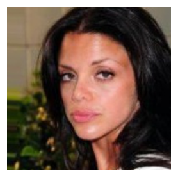

In [0]:
idx=87
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            #preds[0,str(data.valid_ds.y[idx])].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 8, 8])

In [0]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([8, 8])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [0]:
avg_acts

tensor([[0.1034, 0.1023, 0.1387, 0.2085, 0.2783, 0.2995, 0.2313, 0.1974],
        [0.0906, 0.1079, 0.2190, 0.3894, 0.4631, 0.4955, 0.3788, 0.2365],
        [0.1095, 0.1464, 0.3894, 0.6495, 0.7418, 0.7155, 0.5464, 0.2970],
        [0.1023, 0.2010, 0.6302, 0.7888, 0.8379, 0.7959, 0.6236, 0.3014],
        [0.0982, 0.1906, 0.5904, 0.8319, 0.8355, 0.8397, 0.6737, 0.2643],
        [0.1011, 0.1356, 0.5125, 0.8559, 0.8866, 0.7845, 0.5472, 0.2487],
        [0.1011, 0.0976, 0.3179, 0.6405, 0.6973, 0.5483, 0.4107, 0.2002],
        [0.1688, 0.1903, 0.3171, 0.4994, 0.5306, 0.4285, 0.3684, 0.2605]])

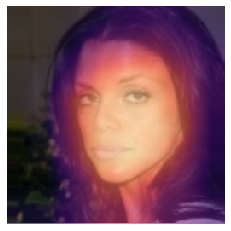

In [0]:
show_heatmap(avg_acts)

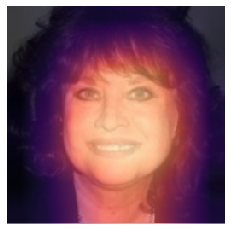

In [0]:
idx=3000
x,y = data.valid_ds[idx]
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

In [0]:
avg_acts

tensor([[0.1253, 0.1553, 0.2261, 0.2258, 0.2435, 0.2421, 0.1829, 0.1647],
        [0.1168, 0.2056, 0.3241, 0.4218, 0.4906, 0.4775, 0.3043, 0.1560],
        [0.1572, 0.2538, 0.5485, 0.7487, 0.8001, 0.7528, 0.4910, 0.1958],
        [0.1513, 0.3196, 0.6766, 0.7723, 0.8394, 0.7972, 0.5853, 0.2456],
        [0.1842, 0.3527, 0.7430, 0.8676, 0.8428, 0.8570, 0.6396, 0.2601],
        [0.1671, 0.3950, 0.6879, 0.8538, 0.9302, 0.8319, 0.6047, 0.2673],
        [0.1303, 0.2625, 0.4761, 0.6584, 0.7470, 0.6841, 0.4792, 0.1894],
        [0.1909, 0.2470, 0.4402, 0.6323, 0.6704, 0.6499, 0.4185, 0.2435]])

In [0]:
# USAGE
"""
python detect_features.py \
--input_path "../data/celeba/faces/" \
--output_path "./" \
--save_video False
"""

import click
import numpy as np
import cv2
import imutils
from pathlib import Path
from fastai.vision.data import ImageList
from fastai.vision.learner import create_cnn
from fastai.vision import models
from fastai.vision.image import pil2tensor, Image


@click.command()
@click.option(
    "--input_path",
    "-ip",
    default="./",
    required=True,
    help="Path to model and labels file",
)
@click.option(
    "--output_path", "-op", default="./", required=True, help="Path to the output video"
)
@click.option("--save_video", "-s", default=True, type=bool, help="Want to save video?")
def detect_facial_attributes(input_path, output_path, save_video):
    path = Path(input_path)

    # Creating a databunch
    imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    data = (
        ImageList.from_csv(path, csv_name="labels.csv")
            .no_split()
            .label_from_df(label_delim=" ")
            .transform(None, size=128)
            .databunch(no_check=True)
            .normalize(imagenet_stats)
    )

    # Loading our model
    learn = create_cnn(data, models.resnet50, pretrained=False)
    learn.load("ff_stage-2-rn50")

    # Loading HAAR cascade
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    cap = cv2.VideoCapture(0)
    if save_video:
        out = cv2.VideoWriter(output_path + "output.avi", -1, 20.0, (640, 480))

    while True:
        # Capture frame-by-frame
        _, frame = cap.read()

        # Our operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Find faces using Haar cascade
        face_coord = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

        ## Looping through each face
        for coords in face_coord:

            ## Finding co-ordinates of face
            X, Y, w, h = coords

            ## Finding frame size
            H, W, _ = frame.shape

            ## Computing larger face co-ordinates
            X_1, X_2 = (max(0, X - int(w * 0.35)), min(X + int(1.35 * w), W))
            Y_1, Y_2 = (max(0, Y - int(0.35 * h)), min(Y + int(1.35 * h), H))

            ## Cropping face and changing BGR To RGB
            img_cp = frame[Y_1:Y_2, X_1:X_2].copy()
            img_cp1 = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)

            ## Prediction of facial featues
            prediction = str(
                learn.predict(Image(pil2tensor(img_cp1, np.float32).div_(255)))[0]
            ).split(";")
            label = (
                " ".join(prediction)
                if "Male" in prediction
                else "Female " + " ".join(prediction)
            )
            label = (
                " ".join(prediction)
                if "No_Beard" in prediction
                else "Beard " + " ".join(prediction)
            )

            ## Drawing facial boundaries
            cv2.rectangle(
                img=frame,
                pt1=(X, Y),
                pt2=(X + w, Y + h),
                color=(128, 128, 0),
                thickness=2,
            )

            ## Drawing facial attributes identified
            label_list = label.split(" ")
            for idx in range(1, len(label_list) + 1):
                cv2.putText(
                    frame,
                    label_list[idx - 1],
                    (X, Y - 14 * idx),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.45,
                    (0, 128, 0),
                    2,
                )

        # Display the resulting frame
        cv2.imshow("frame", frame)

        ## Save the resulting frame
        if save_video:
            out.write(frame)

        ## Escape keys
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # When everything done, release the capture
    cap.release()
    if save_video:
        out.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    detect_facial_attributes()